# Entrainment-LF17

This notebook runs [GOTM](https://gotm.net/) simulating the entrainment of an initial mixed layer under various constant wind, waves, and destabilizing surface buoyancy flux forcing as described in [Li and Fox-Kemper, 2017](https://doi.org/10.1175/JPO-D-17-0085.1) (LF17). The idealized initial conditions and surface forcing are consisten with the LES in LF17 so the results are directly comparable. See Section 3.3 and 4.4.1 of [Li et al., 2019](https://doi.org/10.1029/2019MS001810).

Note that this notebook will setup 54 GOTM runs for each chosen turbulence closure method, which take up to 500 MB space.  

In [1]:
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("/scratch/ds2/ab2462/KPP/gotmtool")
from gotmtool import *
from gotmtool.stokesdrift import stokes_drift_dhh85

## Create a model
Create a model with environment file `../../.gotm_env.yaml`, which is created by `gotm_env_init.py`. 

In [2]:
m = Model(name='Entrainment-LF17', environ='/scratch/ds2/ab2462/KPP/gotmtool/.gotm_env.yaml')

Take a look at what are defined in the environment file.

In [3]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /scratch/ds2/ab2462/KPP/gotm/code
   gotmdir_data: /scratch/ds2/ab2462/KPP/gotm/data
  gotmdir_build: /scratch/ds2/ab2462/KPP/gotm/build
    gotmdir_exe: /scratch/ds2/ab2462/KPP/gotm/exe
    gotmdir_run: /scratch/ds2/ab2462/KPP/gotm/run
 gotmdir_figure: /scratch/ds2/ab2462/KPP/gotm/figure
   gotmdir_tool: /scratch/ds2/ab2462/KPP/gotmtool


## Build the model

In [4]:
%%time
m.build()

CPU times: user 9.2 ms, sys: 15.9 ms, total: 25.1 ms
Wall time: 5.66 s


## Configuration
Initialize the GOTM configuration

In [5]:
cfg = m.init_config()

 ------------------------------------------------------------------------
 GOTM started on 2025/06/04 at 21:26:52
 ------------------------------------------------------------------------
    initialize_gotm
 ------------------------------------------------------------------------
        Reading configuration from: gotm.yaml
        configuring modules ....
    init_airsea_yaml
        done
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
    init_cvmix_yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
    init_density()
            rho0=     1027.0000000000000     
        done.
 Your configuration has been written to /scratch/ds2/ab2462/KPP/gotm/run/Entrainment-LF17/gotm.yaml.
STOP 0


Generating default configuration at '/scratch/ds2/ab2462/KPP/gotm/run/Entrainment-LF17/gotm.yaml'...
Done!


Update the configuration

In [6]:
# setup
title = 'Entrainment - LF17'
nlev = 256
depth = 163.84
cfg['title'] = title
cfg['location']['name'] = 'OSMOSIS'
cfg['location']['latitude'] = 45.0
cfg['location']['longitude'] = 0.0
cfg['location']['depth'] = depth
cfg['time']['start'] = '2000-01-01 00:00:00'
cfg['time']['stop']  = '2000-01-03 00:00:00'
cfg['time']['dt']    = 60.0
cfg['grid']['nlev']  = nlev

# output
cfg['output'] = {}
cfg['output']['gotm_out'] = {}
cfg['output']['gotm_out']['use'] = True
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'dt'
cfg['output']['gotm_out']['time_step'] = 15
cfg['output']['gotm_out']['variables'] = [{}]
cfg['output']['gotm_out']['variables'][0]['source'] = '*'

# forcing
datadir = m.environ['gotmdir_data']+'/examples/Entrainment-LF17'
cfg['temperature']['method'] = 'file'
cfg['temperature']['file'] = datadir+'/t_prof.dat'
cfg['salinity']['method'] = 'file'
cfg['salinity']['file'] = datadir+'/s_prof.dat'
cfg['surface']['fluxes']['heat']['method'] = 'constant'
cfg['surface']['fluxes']['tx']['method'] = 'constant'
cfg['surface']['fluxes']['ty']['method'] = 'constant'
cfg['surface']['swr']['method'] = 'constant'
cfg['surface']['precip']['method'] = 'constant'
cfg['waves']['stokes_drift']['us']['method'] = 'file'
cfg['waves']['stokes_drift']['vs']['method'] = 'file'
cfg['waves']['stokes_drift']['us']['file'] = 'us_prof.dat'
cfg['waves']['stokes_drift']['us']['column'] = 1
cfg['waves']['stokes_drift']['vs']['file'] = 'us_prof.dat'
cfg['waves']['stokes_drift']['vs']['column'] = 2

# EOS -- use linear
cfg['equation_of_state']['method'] = 'linear_custom'
cfg['equation_of_state']['linear']['T0'] = 12.0
cfg['equation_of_state']['linear']['S0'] = 35.0
cfg['equation_of_state']['linear']['alpha'] = 2e-4
cfg['equation_of_state']['linear']['beta'] = 7.5e-4
cfg['equation_of_state']['rho0'] = 1000.0


## Set the turbulence methods
- GLS-C01A: the generic length scale (GLS; [Umlauf and Burchard, 2003](https://doi.org/10.1357/002224003322005087)) model in the $k$-$\epsilon$ formulation with the weak-equilibrium stability function by [Canuto et al., 2001](https://doi.org/10.1175/1520-0485(2001)031%3C1413:OTPIOP%3E2.0.CO;2) (C01A).
- KPP-CVMix: KPP implementation in CVMix ([Large et al., 1994](https://doi.org/10.1029/94RG01872), [Griffies et al., 2015](https://github.com/CVMix/CVMix-description/raw/master/cvmix.pdf))
- KPPLT-VR12: KPP with Langmuir mixing ([Li et al., 2016](https://doi.org/10.1016%2Fj.ocemod.2015.07.020))
- KPPLT-LF17: KPP with Lanmguir turbulence enhanced entrainment ([Li and Fox-Kemper, 2017](https://doi.org/10.1175%2FJPO-D-17-0085.1))

In [7]:
turbmethods = [
    'GLS-C01A',
    'KPP-CVMix',
    'KPPLT-VR12',
    'KPPLT-LF17',
    ]

## Create a list of configurations

In [8]:
# heat flux (W/m^2)                                                                                                                                                               
heatflux = {'BF05':   -5.0, 'BF10':  -10.0, 'BF25':  -25.0, 'BF50': -50.0,
            'BF1h': -100.0, 'BF2h': -200.0, 'BF3h': -300.0, 'BF5h':-500.0}

# 10-meter wind (m/s)
u10  = {'WD05':   5.0, 'WD08':     8.0, 'WD10':  10.0}
v10  = {'WD05':   0.0, 'WD08':     0.0, 'WD10':   0.0}
taux = {'WD05': 0.036, 'WD08': 0.09216, 'WD10': 0.144}
tauy = {'WD05':   0.0, 'WD08':     0.0, 'WD10':   0.0}

# wave age (unitless)
wave_age = {'WV00': 1.2, 'WV01': 1.2, 'WV02': 1.0, 'WV03': 0.8, 'WV04': 0.6}

# LF17 case list
cases = [
    # 'BF05WD05WV00',                                                                                                                                                                    
    # 'BF05WD05WV01',
    # 'BF05WD05WV02',
    # 'BF05WD05WV03',
    # 'BF05WD05WV04',
    # 'BF05WD08WV00',
    # 'BF05WD08WV01',
    # 'BF05WD08WV02',
    # 'BF05WD08WV03',
    # 'BF05WD08WV04',
    # 'BF05WD10WV00',
    # 'BF05WD10WV01',
    # 'BF05WD10WV02',
    # 'BF05WD10WV03',
    # 'BF05WD10WV04',
    # 'BF10WD05WV00',
    # 'BF10WD05WV01',
    # 'BF10WD05WV03',
    # 'BF1hWD05WV00',
    # 'BF1hWD05WV01',
    # 'BF1hWD05WV03',
    # 'BF1hWD08WV00',
    # 'BF1hWD08WV01',
    # 'BF1hWD08WV03',
    # 'BF1hWD10WV00',
    # 'BF1hWD10WV01',
    # 'BF1hWD10WV03',
    # 'BF25WD05WV00',
    # 'BF25WD05WV01',
    # 'BF25WD05WV03',
    # 'BF25WD08WV00',
    # 'BF25WD08WV01',
    # 'BF25WD08WV03',
    # 'BF25WD10WV00',
    # 'BF25WD10WV01',
    # 'BF25WD10WV03',
    # 'BF2hWD05WV00',
    # 'BF2hWD05WV01',
    # 'BF2hWD05WV03',
    # 'BF3hWD05WV00',
    # 'BF3hWD05WV01',
    'BF3hWD05WV03',
    # 'BF50WD05WV00',
    # 'BF50WD05WV01',
    # 'BF50WD05WV03',
    # 'BF50WD08WV00',
    # 'BF50WD08WV01',
    # 'BF50WD08WV03',
    # 'BF50WD10WV00',
    # 'BF50WD10WV01',
    # 'BF50WD10WV03',
    # 'BF5hWD05WV00',
    # 'BF5hWD05WV01',
    # 'BF5hWD05WV03',
    ]

Set the depth and time for `stokes_drift_dhh85()` and `dat_dump_pfl()`. The former computes Stokes drift using the [Donelan et al., 1985](https://doi.org/10.1098/rsta.1979.0079) spectrum, and the latter write profile data in the GOTM input format.

In [9]:
dz = depth/nlev
z = np.linspace(-0.5*dz, -depth+0.5*dz, nlev)
time =  pd.date_range(cfg['time']['start'], freq='D', periods=1)
nt = len(time)

In [10]:
cfgs = []
labels = []
for i, casename in enumerate(cases):
    print(casename)
    # set surface fluxes
    heatflux_label = casename[:4]
    wind_label = casename[4:8]
    wave_label = casename[8:]
    wind_speed = np.sqrt(u10[wind_label]**2+v10[wind_label]**2)
    cfg['surface']['fluxes']['heat']['constant_value'] = heatflux[heatflux_label]
    cfg['surface']['fluxes']['tx']['constant_value'] = taux[wind_label]
    cfg['surface']['fluxes']['ty']['constant_value'] = tauy[wind_label]
    cfg['surface']['fluxes']['ty']['constant_value'] = tauy[wind_label]

    cfg['surface']['precip']['constant_value'] = -1e-7
    # compute Stokes drift
    xcomp = u10[wind_label]/wind_speed
    ycomp = v10[wind_label]/wind_speed
    stokes_drift = stokes_drift_dhh85(z, wind_speed, wave_age[wave_label])
    us_arr = np.tile(stokes_drift, (nt,1)) * xcomp
    vs_arr = np.tile(stokes_drift, (nt,1)) * ycomp
    # set turbulence methods
    for turbmethod in turbmethods: 
        run_label = casename+'/'+turbmethod
        labels.append(run_label)
        run_dir = m.environ['gotmdir_run']+'/'+m.name+'/'+run_label
        os.makedirs(run_dir, exist_ok=True)
        dat_dump_pfl(time, z, [us_arr, vs_arr], run_dir+'/us_prof.dat')
        if turbmethod == 'GLS-C01A':
            cfg['turbulence']['turb_method'] = 'second_order'
            cfg['turbulence']['tke_method'] = 'tke'
            cfg['turbulence']['len_scale_method'] = 'gls'
            cfg['turbulence']['scnd']['method'] =  'weak_eq_kb_eq'
            cfg['turbulence']['scnd']['scnd_coeff'] =  'canuto-a'
            cfg['turbulence']['turb_param']['length_lim'] = 'false'
            cfg['turbulence']['turb_param']['compute_c3'] = 'true'
            cfg['turbulence']['turb_param']['Ri_st'] = 0.25
            cfg['turbulence']['generic']['gen_m'] = 1.5 
            cfg['turbulence']['generic']['gen_n'] = -1.0
            cfg['turbulence']['generic']['gen_p'] = 3.0 
            cfg['turbulence']['generic']['cpsi1'] = 1.44
            cfg['turbulence']['generic']['cpsi2'] = 1.92
            cfg['turbulence']['generic']['cpsi3minus'] = -0.63
            cfg['turbulence']['generic']['cpsi3plus'] = 1.0 
            cfg['turbulence']['generic']['sig_kpsi'] = 1.0 
            cfg['turbulence']['generic']['sig_psi'] = 1.3
        elif turbmethod == 'KPP-CVMix':
            cfg['turbulence']['turb_method'] = 'cvmix'
            cfg['cvmix']['surface_layer']['langmuir_method'] = 'none'
        elif turbmethod == 'KPPLT-VR12':
            cfg['turbulence']['turb_method'] = 'cvmix'
            cfg['cvmix']['surface_layer']['langmuir_method'] = 'lwf16'
        elif turbmethod == 'KPPLT-LF17':
            cfg['turbulence']['turb_method'] = 'cvmix'
            cfg['cvmix']['surface_layer']['langmuir_method'] = 'lf17'
        else:
            raise ValueError('Turbulence closure method \'{}\' not defined.'.format(turbmethod))
        cfgs.append(copy.deepcopy(cfg))

BF3hWD05WV03


## Run the model

In [11]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=1)

CPU times: user 31.3 ms, sys: 6.26 ms, total: 37.6 ms
Wall time: 6.91 s


In [22]:
data0.temp.min().values

array(10.754384, dtype=float32)

(-40.0, 0.0)

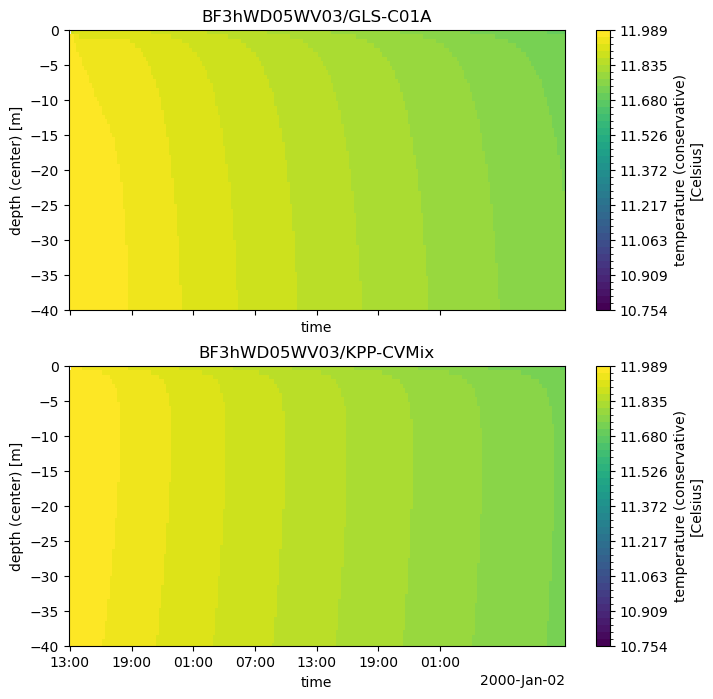

In [23]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(8, 8)
data0 = sims[0].load_data()
levels = np.linspace(data0.temp.min().values, data0.temp.max().values, 41)
data0.temp.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
axarr[0].set_ylim([-40, 0])
data1 = sims[1].load_data()
data1.temp.plot(ax=axarr[1], levels=levels)
axarr[1].set_title(labels[1])
axarr[1].set_ylim([-40, 0])

(-40.0, 0.0)

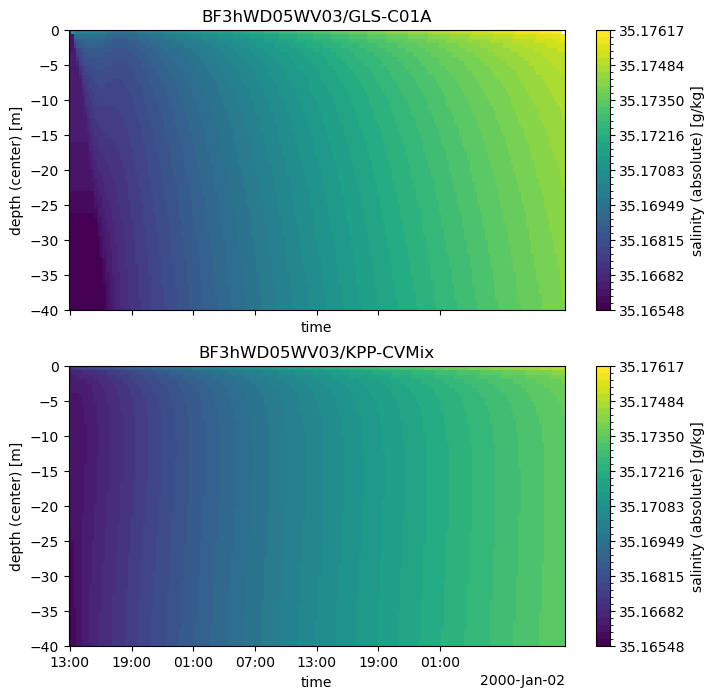

In [24]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(8, 8)
data0 = sims[0].load_data()
levels = np.linspace(data0.salt.min().values, data0.salt.max().values, 41)
data0.salt.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
axarr[0].set_ylim([-40, 0])
data1 = sims[1].load_data()
data1.salt.plot(ax=axarr[1], levels=levels)
axarr[1].set_title(labels[1])
axarr[1].set_ylim([-40, 0])